#  Les Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Librairie re pour traiter des caratères spécifiques
import re
#Librairie de netoyage de tweets
!pip install tweet-preprocessor
import preprocessor as tpr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC

# Creation du DataFrame

In [2]:
# Importation du premier dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset.json'))

In [3]:
sarc = pd.DataFrame(data)

In [4]:
# Importation du deuxieme dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))

In [5]:
sarc_2 = pd.DataFrame(data)

# Comparaison et fusion des 2 datasets

In [6]:
sarc_2['is_sarcastic'].mean()

0.476396799329117

In [7]:
sarc['is_sarcastic'].mean()

0.43895316185555433

In [8]:
# Fusion des 2 datasets et suppression des doublons
sarc = pd.concat([sarc,sarc_2])
sarc = sarc.drop_duplicates()
sarc.reset_index(drop=True,inplace=True)

In [9]:
sarc.describe(include='all')

,article_link,headline,is_sarcastic
count,28617,28617,28617.000000
unique,28617,28503,NaN
top,https://www.huffingtonpost.com/entry/ricky-ger...,"'no way to prevent this,' says only nation whe...",NaN
freq,1,12,NaN
mean,NaN,NaN,0.476395
std,NaN,NaN,0.499451
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


In [10]:
# Check des cases vides
sarc.isnull().any()

article_link    False
headline        False
is_sarcastic    False
dtype: bool

# Data Cleaning

In [11]:
# Utilisation de la librairie re pour traiter des caratères spécifiques
# Choix des caractères à effacer et à remplacer

replace_q = re.compile("(\?)")
replace_ex = re.compile("(\!)")
to_remove = re.compile("(\.)|(\;)|(\:)|(\')|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")

In [12]:
# Fonction de cleaning de la data utilisant tweet-processor et re

def cleaner(line):
    tmp_line = tpr.clean(line)
    tmp_line = replace_q.sub(" ? ",tmp_line.lower())
    tmp_line = replace_ex.sub(" ! ",tmp_line)
    tmp_line = to_remove.sub("",tmp_line)
    return tmp_line

In [13]:
# Cleaning de la data
h_clean = sarc['headline'].apply(cleaner)

# Ajout de la data clean au dataset
sarc["headline_clean"] = h_clean

In [14]:
sarc

,article_link,headline,is_sarcastic,headline_clean
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...
...,...,...,...,...
28612,https://www.theonion.com/tyson-holds-contest-t...,tyson holds contest to let fans submit new ide...,1,tyson holds contest to let fans submit new ide...
28613,https://politics.theonion.com/increasingly-coc...,increasingly cocky bernie sanders announces he...,1,increasingly cocky bernie sanders announces he...
28614,https://www.theonion.com/cash-strapped-zuckerb...,cash-strapped zuckerberg forced to sell 11 mil...,1,cash-strapped zuckerberg forced to sell millio...
28615,https://local.theonion.com/grocery-store-bar-a...,grocery store bar actually has great little ha...,1,grocery store bar actually has great little ha...


In [15]:
sarc['headline'][28589]

'stock value of billions of otherwise worthless data, photos, videos, opinions plummets'

In [16]:
sarc['headline_clean'][28589]

'stock value of billions of otherwise worthless data photos videos opinions plummets'

# Construction des sets Train et Test

In [17]:
# Construction des features et de la target
x = sarc.headline_clean.values
y = sarc.is_sarcastic.values

x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size=0.3,
                                                   stratify=y)

# Vectorisation

In [18]:
#Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(binary=True, stop_words="english")


x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [19]:
#Vectorisation avec TfidfVectorizer
t_vectorizer = TfidfVectorizer(use_idf=True, stop_words="english")

t_vectorized = t_vectorizer.fit(x)

x_train_tfidf = t_vectorizer.transform(x_train)
x_test_tfidf = t_vectorizer.transform(x_test)

# Construction des modèles

**Regression Logistique**

In [20]:
# Regression Logistique avec CountVectorizer

cv_reg = LogisticRegression()
cv_reg.fit(x_train_vec,y_train)

C:\Users\shexx\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
y_train_vec_pred = cv_reg.predict(x_train_vec)

In [22]:
y_test_vec_pred = cv_reg.predict(x_test_vec)

In [23]:
# score train
cv_reg.score(x_train_vec,y_train)


0.9527732015376167

In [24]:
# score train
cv_reg.score(x_test_vec,y_test)

0.7936175168879571

In [25]:
# Regression Logistique avec TfidfVectorizer

tv_reg = LogisticRegression()
tv_reg.fit(x_train_tfidf,y_train)

LogisticRegression()

In [26]:
# score train
tv_reg.score(x_train_tfidf,y_train)

0.9032998851779741

In [27]:
# score test
tv_reg.score(x_test_tfidf,y_test)

0.7889587700908456

    Matrices de confusion

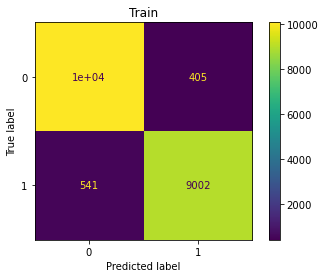

accuracy-score on train set :  0.9527732015376167
precision-score on train set :  0.9569469543956628
recall-score on train set :  0.9433092318977261
F1-score on train set :  0.9500791556728233


In [28]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_reg.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_reg.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_reg.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_reg.predict(x_train_vec)))

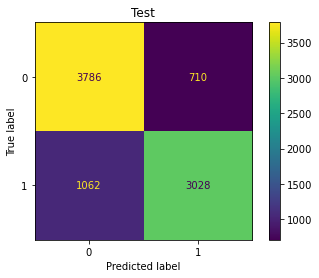

accuracy-score on test set :  0.7936175168879571
precision-score on test set :  0.8100588550026753
recall-score on test set :  0.7403422982885085
F1-score on test set :  0.7736331119059786


In [29]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_reg.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_reg.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_reg.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_reg.predict(x_test_vec)))

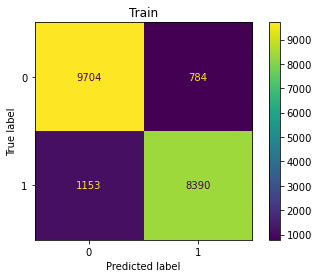

accuracy-score on train set :  0.9032998851779741
precision-score on train set :  0.9145410943972095
recall-score on train set :  0.8791784554123441
F1-score on train set :  0.8965111930330715


In [30]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_train_tfidf,y_train)
cm_tfidf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_reg.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_reg.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_reg.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_reg.predict(x_train_tfidf)))

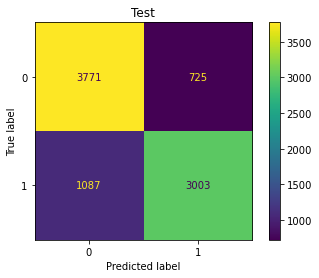

accuracy-score on test set :  0.7889587700908456
precision-score on test set :  0.8055257510729614
recall-score on test set :  0.7342298288508557
F1-score on test set :  0.7682271680736762


In [31]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_test_tfidf,y_test)
cm_tfidf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_reg.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_reg.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_reg.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_reg.predict(x_test_tfidf)))

**Random Forest**

In [72]:
# Randomforest avec CountVectorizer

cv_rf = RandomForestClassifier(n_estimators=75, max_depth=20)
cv_rf.fit(x_train_vec,y_train)

RandomForestClassifier(max_depth=20, n_estimators=75)

In [68]:
# score train
cv_rf.score(x_train_vec,y_train)

0.7072038340572113

In [69]:
# score test
cv_rf.score(x_test_vec,y_test)

0.6659678546471

In [35]:
# Randomforest avec TfidfVectorizer

tv_rf = RandomForestClassifier()
tv_rf.fit(x_train_tfidf,y_train)

RandomForestClassifier()

In [36]:
# score train
tv_rf.score(x_train_tfidf,y_train)

1.0

In [37]:
# score test
tv_rf.score(x_test_tfidf,y_test)

0.757745166550198

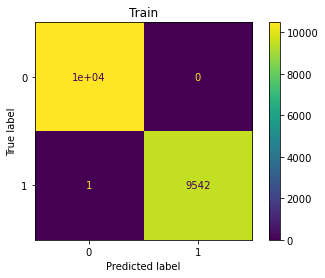

accuracy-score on train set :  0.9999500773800609
precision-score on train set :  1.0
recall-score on train set :  0.9998952111495337
F1-score on train set :  0.9999476028294472


In [38]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_rf.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_rf.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_rf.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_rf.predict(x_train_vec)))

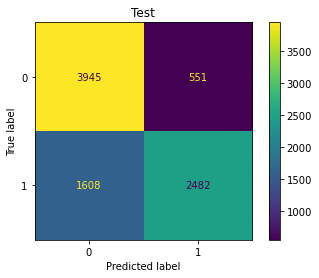

accuracy-score on test set :  0.7485441416259027
precision-score on test set :  0.8183316848005275
recall-score on test set :  0.6068459657701711
F1-score on test set :  0.6968973747016706


In [39]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_rf.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_rf.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_rf.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_rf.predict(x_test_vec)))

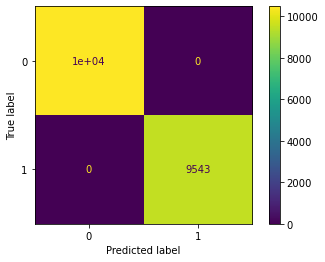

accuracy-score on train set :  1.0
precision-score on train set :  1.0
recall-score on train set :  1.0
F1-score on train set :  1.0


In [40]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_train_tfidf,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_rf.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_rf.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_rf.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_rf.predict(x_train_tfidf)))

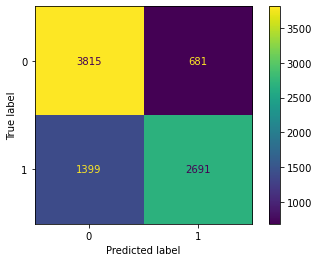

accuracy-score on test set :  0.757745166550198
precision-score on test set :  0.7980427046263345
recall-score on test set :  0.6579462102689486
F1-score on test set :  0.7212543554006969


In [41]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_test_tfidf,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_rf.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_rf.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_rf.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_rf.predict(x_test_tfidf)))

**Support Vector Machine**

In [42]:
# SVM avec CountVectorizer

cv_svm = SVC()
cv_svm.fit(x_train_vec,y_train)

SVC()

In [43]:
# score train
cv_svm.score(x_train_vec,y_train)

0.9717937197344116

In [44]:
# score test
cv_svm.score(x_test_vec,y_test)

0.7884928954111344

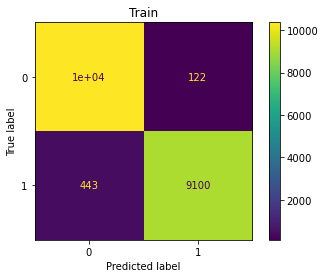

accuracy-score on train set :  0.9717937197344116
precision-score on train set :  0.9867707655606159
recall-score on train set :  0.9535785392434245
F1-score on train set :  0.9698907540634158


In [45]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_svm.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_svm.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_svm.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_svm.predict(x_train_vec)))

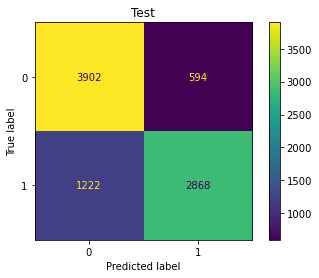

accuracy-score on test set :  0.7884928954111344
precision-score on test set :  0.82842287694974
recall-score on test set :  0.7012224938875306
F1-score on test set :  0.7595338983050848


In [46]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_svm.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_svm.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_svm.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_svm.predict(x_test_vec)))

In [47]:
# SVM avec TfidfVectorizer

tv_svm = SVC()
tv_svm.fit(x_train_tfidf,y_train)

SVC()

In [48]:
# score train
tv_svm.score(x_train_tfidf,y_train)

0.9892167140931556

In [49]:
# score test
tv_svm.score(x_test_tfidf,y_test)

0.7969951083158631

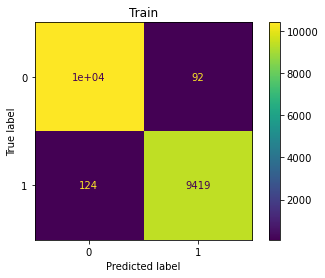

accuracy-score on train set :  0.9892167140931556
precision-score on train set :  0.9903269898012828
recall-score on train set :  0.9870061825421775
F1-score on train set :  0.9886637976277948


In [50]:
#Matrice et score pour train avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_train_tfidf,y_train)
cm_tf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_svm.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_svm.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_svm.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_svm.predict(x_train_tfidf)))

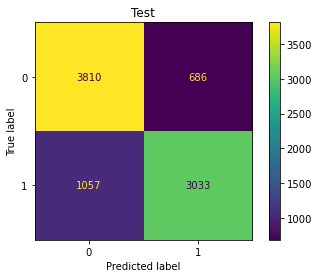

accuracy-score on test set :  0.7969951083158631
precision-score on test set :  0.8155418123151384
recall-score on test set :  0.7415647921760391
F1-score on test set :  0.7767960046100651


In [51]:
#Matrice et score pour test avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_test_tfidf,y_test)
cm_tf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_svm.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_svm.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_svm.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_svm.predict(x_test_tfidf)))

Gradient Boosting Classifier

In [ ]:
xgb = GradientBoostingClassifier()
xgb.fit(x_train_vec,y_train)
xgb.score(x_train_vec,y_train)
xgb.score(x_test_vec,y_test)